# Versión oficial para cargar la data de entrenamiento
A su gusto

# Librerías

In [1]:
import os
import json
import re
import math
import random
from typing import Any, Dict, List, Optional
import csv

import torch
from torch.utils.data import DataLoader, Dataset as TorchDataset
from torch.optim import AdamW
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.utils.checkpoint
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

# Importar archivos .py personalizados
import evaluation_metric as custom_metrics #el archivo .py con las métricas personalizadas, proveida por el curso
import shared_functions as custom_sharfun  #el archivo .py con funciones compartidas

#import warnings
from importlib.metadata import version

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    get_scheduler
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from transformers import logging as hf_logging
hf_logging.set_verbosity_warning()

In [2]:
# Ignorar las warnings
#warnings.filterwarnings("ignore")  → dejar esto al final para la entrega, dado que se debe revisar que se debe mejorar en el código

# Versiones utilizadas
librerias = [
    "numpy",
    "matplotlib",
    "torch",
    "tqdm",
    "datasets",
    "transformers",
    "peft",
    "importlib-metadata"
]
for library in librerias:
    print(library, ": ", version(library))

!python --version

numpy :  1.26.4
matplotlib :  3.10.5
torch :  2.8.0+cu128
tqdm :  4.67.1
datasets :  4.0.0
transformers :  4.56.0
peft :  0.18.0
importlib-metadata :  8.7.0
Python 3.12.12


# Variables globales y funciones auxiliares

### Valores por defecto

In [ ]:
# Directorios
TOTAL_FILES_TO_TRAIN = 1 # aquí ponga el número total de archivos json que desea usar para entrenar
DATA_PATH = "data/train" # aqui ponga los archivos json de entrenamiento, descargados de la competencia
OUTPUT_DIR = "output/results"
EXPECTED_JSON_FILE = "data/template/expected_output.json"
EXPECTED_JSON = None
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Modelo
MODEL_NAME = "Qwen/Qwen3-0.6B-Base"

# Configuración del dispositivo + semillas
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
GLB_SEED = 42
torch.manual_seed(GLB_SEED)
random.seed(GLB_SEED)
np.random.seed(GLB_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(GLB_SEED)

Using device: cuda


### Valores globales de prueba

In [4]:
# Data / tokenization
TEST_SIZE = 0.2
MAX_LENGTH = 2048 #menor de este valor la tokenización está truncando el JSON objetivo con 1024 funciona bien

# Dataloader
BATCH_SIZE = 1
#NUM_WORKERS = 2

# Entrenamiento
GRAD_ACCUM_STEPS = 4
EPOCHS = 4
WARMUP_RATIO = 0.05 # 5% de los steps totales, sugerencia otra 0.03
#WARMUP_STEPS = 10 # con 10 va bien # revisar este 100, mejor usar WARMUP_RATIO

# AdamW
LEARNING_RATE = 2e-4 # con 2e-4 es agresivo pero funciona bien, riesgo de overfitting
WEIGHT_DECAY = 0.01
BETAS = (0.9, 0.999)
EPS = 1e-8
SCHEDULER_TYPE = "linear" # linear, cosine, cosine_with_restarts, polynomial, constant, constant_with_warmup  #cosine no va bien
CLIP_NORM = 1.0

# LoRA
LORA_R = 16
LORA_ALPHA = 32
LORA_DROPOUT = 0.05
TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj"]

# Evaluación
NUM_VAL_EXAMPLES = 45
GEN_MAX_NEW_TOKENS = 512
BEAM_CANDIDATES = 4

# Carga de archivos y datos

Cargar archivo ejemplo JSON esperado para predicción, aunque no se usa todavía, es para mejorar un poco la prediccion...

In [5]:
with open(EXPECTED_JSON_FILE, "r", encoding="utf-8") as f:
    EXPECTED_JSON = json.load(f)

**Cargar dataset**   
Los N archivos con los que desea entrenar el modelo.

In [9]:
# Cargar datos de entrenamiento, lea los archivos de la carpeta train
raw_data = []
files = sorted([f for f in os.listdir(DATA_PATH) if f.endswith(".json")])[:TOTAL_FILES_TO_TRAIN]

for file_name in files:
    file_path = os.path.join(DATA_PATH, file_name)
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
        # Si cada archivo tiene una lista de diccionarios, la agregamos
        if isinstance(data, list):
            raw_data.extend(data)
        elif isinstance(data, dict):
            raw_data.append(data)
        else:
            raise ValueError(f"Formato no esperado en {file_name}")

print(f"Total training files loaded: {len(raw_data)}")

Total training files loaded: 1000


In [13]:
# convert to Hugging Face Dataset
hf_dataset = Dataset.from_list(raw_data)

# split train / validation
split = hf_dataset.train_test_split(test_size=TEST_SIZE, seed=GLB_SEED)
train_list = split['train']
val_list = split['test']

print(f"Train examples: {len(train_list)}, Val examples: {len(val_list)}")
print(hf_dataset)
print(f"Número de registros cargados: {len(hf_dataset)}")
print(type(hf_dataset))

Train examples: 800, Val examples: 200
Dataset({
    features: ['natural_language', 'json_data'],
    num_rows: 1000
})
Número de registros cargados: 1000
<class 'datasets.arrow_dataset.Dataset'>


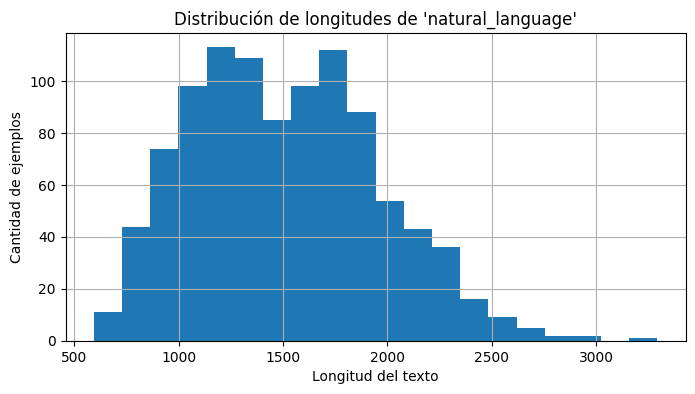

In [14]:
# Obtener longitudes de texto para ajustar MAX_LENGTH - histograma
longitudes = [len(item["natural_language"]) for item in raw_data]
plt.figure(figsize=(8, 4))
plt.hist(longitudes, bins=20)  # puedes ajustar el número de bins
plt.title("Distribución de longitudes de 'natural_language'")
plt.xlabel("Longitud del texto")
plt.ylabel("Cantidad de ejemplos")
plt.grid(True)
plt.show()

In [15]:
print("Cargando tokenizer y modelo (esto puede tardar)...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True) # dejar trust_remote_code=True para Qwen
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    dtype=torch.bfloat16
)

# preparar para k-bit training
model = prepare_model_for_kbit_training(model)

# Desactivar cache y habilitar checkpointing seguro
model.config.use_cache = False
try:
    model.gradient_checkpointing_enable(gradient_checkpointing_kwargs={"use_reentrant": False})
except TypeError:
    # fallback if the signature is different
    model.gradient_checkpointing_enable()
torch.utils.checkpoint.use_reentrant = False

# Configurar LoRA
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=TARGET_MODULES,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Cargando tokenizer y modelo (esto puede tardar)...
trainable params: 4,587,520 || all params: 600,637,440 || trainable%: 0.7638


## Construcción del prompt para que genere el JSON

In [17]:
# Tokenizar datos de entrenamiento y validación
train_tokens = [custom_sharfun.tokenize_example_textpair(custom_sharfun.build_training_example(x), MAX_LENGTH, tokenizer) for x in train_list]
val_tokens = [custom_sharfun.tokenize_example_textpair(custom_sharfun.build_training_example(x), MAX_LENGTH, tokenizer) for x in val_list]

# Simple Dataset + collate_fn (dinámico)
class SimpleTorchDataset(TorchDataset):
    def __init__(self, tokens_list):
        self.data = tokens_list
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return {k: v for k, v in self.data[idx].items()}
    
train_dataset = SimpleTorchDataset(train_tokens)
val_dataset = SimpleTorchDataset(val_tokens)

def collate_fn(batch):
    return {
        'input_ids': torch.stack([b['input_ids'] for b in batch]),
        'attention_mask': torch.stack([b['attention_mask'] for b in batch]),
        'labels': torch.stack([b['labels'] for b in batch])
    }

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

## Variación de parámetros para optimizador

 Optimizer (intenta Adam8bit de bitsandbytes, si no fallback a AdamW de torch).

 Notas:
 Adam8bit + get_scheduler cosine: no funciono bien, F1 siempre da cero, mejor AdamW

In [18]:
# Optimizer + Scheduler
total_steps_per_epoch  = math.ceil(len(train_loader) / GRAD_ACCUM_STEPS)
total_training_steps = EPOCHS * total_steps_per_epoch
num_warmup_steps = int(total_training_steps * WARMUP_RATIO) # warmup calculado desde warmup_ratio

print(f"Total training steps: {total_training_steps}, Warmup steps: {num_warmup_steps}")

# Optimizador
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(trainable_params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, betas=BETAS, eps=EPS)

# SCHEDULER CON WARMUP
scheduler = get_scheduler(name=SCHEDULER_TYPE, 
                          optimizer=optimizer, 
                          num_warmup_steps=num_warmup_steps, 
                          num_training_steps=total_training_steps)

Total training steps: 800, Warmup steps: 40


In [ ]:
#raise Exception("STOP - revisar código antes de continuar")

In [19]:
# Entrenamiento manual con AMP (torch.amp) y tqdm
scaler = torch.amp.GradScaler(device='cuda') if DEVICE.startswith('cuda') else torch.amp.GradScaler()
model.to(DEVICE)
model.train()

global_step = 0
optimizer.zero_grad()
for epoch in range(EPOCHS):
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{EPOCHS}")
    optimizer.zero_grad()
    for step, batch in pbar:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        with torch.amp.autocast(device_type='cuda' if DEVICE.startswith('cuda') else 'cpu'):
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss / GRAD_ACCUM_STEPS

        scaler.scale(loss).backward()
        running_loss += loss.item() * GRAD_ACCUM_STEPS

        # UPDATE BLOCK: only when accumulation completes
        if (step + 1) % GRAD_ACCUM_STEPS == 0 or (step + 1) == len(train_loader):
            scaler.unscale_(optimizer)  # 1) Unscale gradients (necessary for clipping)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM) # 2) Clip gradients
            scaler.step(optimizer) # 3) Optimizer step (scaled)
            scheduler.step() # 4) Scheduler step → usa warmup aquí
            optimizer.zero_grad() # 5) Clear gradients
            scaler.update()  # 6) Scaler update
            global_step += 1

            avg_loss = running_loss / (step + 1)
            pbar.set_postfix({'loss': f"{avg_loss:.4f}", 'lr': scheduler.get_last_lr()[0]})
            #pbar.set_postfix({ "loss": f"{running_loss / (step+1):.4f}", "lr": scheduler.get_last_lr()[0]})

    print(f"Epoch {epoch+1} finished — avg loss: {running_loss / len(train_loader):.4f}")

Epoch 1/4:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch 1 finished — avg loss: 1.4639


Epoch 2/4:   0%|          | 0/800 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Entrenando modelo se demora: 11 minutos x epoca

In [20]:
# Guardar modelo para validar en datos test. 👈 aqui ver como se saca el "weights.pt"
OUTPUT_DIR_MODEL = os.path.join(OUTPUT_DIR, "modfinal")
os.makedirs(OUTPUT_DIR_MODEL, exist_ok=True)

model.save_pretrained(OUTPUT_DIR_MODEL)
tokenizer.save_pretrained(OUTPUT_DIR_MODEL)

print('Modelo para restaurar guardado en', OUTPUT_DIR_MODEL)

Modelo para restaurar guardado en output/results\modfinal


## Validación del modelo entrenado en los datos test

In [ ]:
# NUM_VAL_EXAMPLES = 45 # si se desea hacer subset, de lo contrario dejar todo
# usar NUM_VAL_EXAMPLES: `for idx, ex in enumerate(tqdm(val_list.select(range(min(NUM_VAL_EXAMPLES, len(val_list)))), desc="Eval")):`

results = []
for idx, ex in enumerate(tqdm(val_list, desc="Evaluación en TEST")):
    text = ex["natural_language"]
    raw = custom_sharfun.generate_json_raw(text=text, max_new_tokens=GEN_MAX_NEW_TOKENS, max_length=MAX_LENGTH, tokenizer=tokenizer, model=model, device=device) # aplica evaluacion del modelo
    pred_obj = custom_sharfun.extract_json_from_text(raw)
    true_json = ex["json_data"]

    if pred_obj is None:
        f1 = 0.0
    else:
        try:
            f1 = custom_metrics.evaluate_json(true_json, json.dumps(pred_obj, ensure_ascii=False))
        except Exception:
            f1 = float(1.0 if pred_obj == true_json else 0.0)

    print(f"Ejemplo {idx}: F1 = {f1:.4f}")
    results.append({"idx": idx, "f1": f1, "raw": raw, "pred": pred_obj, "true": true_json})

In [ ]:
# Validacion de 20% (datos test): 

In [ ]:
 # Resumen de resultados en test: ver histrograma de F1 scores
f1_scores = [r['f1'] for r in results]
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
plt.title("F1 Scores por Ejemplo de Validación")
plt.xlabel("Ejemplo de Validación")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

In [ ]:
results[1] # observar que hay

In [ ]:
# Guardar CSV - resultados de validación
OUTPUT_DIR_VAL = os.path.join(OUTPUT_DIR, "result_validation")
os.makedirs(OUTPUT_DIR_VAL, exist_ok=True)
csv_path = os.path.join(OUTPUT_DIR_VAL, 'validation_results.csv')
with open(csv_path, 'w', encoding='utf-8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['idx','f1','raw','pred','true'])
    writer.writeheader()
    for r in results:
        writer.writerow({
            'idx': r['idx'],
            'f1': r['f1'],
            'raw': r['raw'],
            'pred': json.dumps(r['pred'], ensure_ascii=False),
            'true': json.dumps(r['true'], ensure_ascii=False)
        })
print('CSV guardado en', csv_path)

In [ ]:
# Histograma F1
f1_scores = [r['f1'] for r in results]
plt.figure()
plt.hist(f1_scores, bins=10)
plt.title('Distribución de F1')
plt.xlabel('F1')
plt.ylabel('Frecuencia')
plt.savefig(os.path.join(OUTPUT_DIR, 'f1_distribution.png'))
plt.show()
plt.close()
print('Histograma guardado en', os.path.join(OUTPUT_DIR, 'f1_distribution.png'))

In [ ]:
# Mostrar peores 3 ejemplos
sorted_by_f1 = sorted(results, key=lambda x: x['f1'])
print('\nPeores 3 ejemplos:')
for r in sorted_by_f1[:3]:
    print(f"Ejemplo #{r['idx']} - F1 Score: {r['f1']}")
    print('Texto:', r['raw'])
    print("*"*90)
    print('Pred_normalizado:', r['pred'])
    print('True:', r['true'])
    print('-'*150)